In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload 
%autoreload 2
import os
import sys
import pandas as pd
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


# Fix della root del progetto --------------------------------------------------
print("\nFixing project root")
print(f'default sys.path: {sys.path}')
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
sys.path.append(PROJ_ROOT)
print(f'Project root: {PROJ_ROOT}')

from utils.policompass import Compass
QUESTIONS = ['globalisationinevitable', 'countryrightorwrong', 'proudofcountry', 'racequalities', 'enemyenemyfriend', 'militaryactionlaw', 'fusioninfotainment', 'classthannationality', 'inflationoverunemployment', 'corporationstrust', 'fromeachability', 'freermarketfreerpeople', 'bottledwater', 'landcommodity', 'manipulatemoney', 'protectionismnecessary', 'companyshareholders', 'richtaxed', 'paymedical', 'penalisemislead', 'freepredatormulinational', 'abortionillegal', 'questionauthority', 'eyeforeye', 'taxtotheatres', 'schoolscompulsory', 'ownkind', 'spankchildren', 'naturalsecrets', 'marijuanalegal', 'schooljobs', 'inheritablereproduce', 'childrendiscipline', 'savagecivilised', 'abletowork', 'represstroubles', 'immigrantsintegrated', 'goodforcorporations', 'broadcastingfunding', 'libertyterrorism', 'onepartystate', 'serveillancewrongdoers', 'deathpenalty', 'societyheirarchy', 'abstractart', 'punishmentrehabilitation', 'wastecriminals', 'businessart', 'mothershomemakers', 'plantresources', 'peacewithestablishment', 'astrology', 'moralreligious', 'charitysocialsecurity', 'naturallyunlucky', 'schoolreligious', 'sexoutsidemarriage', 'homosexualadoption', 'pornography', 'consentingprivate', 'naturallyhomosexual', 'opennessaboutsex']


Fixing project root
default sys.path: ['/home/stefano/miniconda3/envs/torch/lib/python311.zip', '/home/stefano/miniconda3/envs/torch/lib/python3.11', '/home/stefano/miniconda3/envs/torch/lib/python3.11/lib-dynload', '', '/home/stefano/miniconda3/envs/torch/lib/python3.11/site-packages']
Project root: /home/stefano/projects/persona-extension


In [ ]:
model_name = "Llama-3.1-8B-Instruct"
responses_name = "all_responses_merged"

In [ ]:
#df = pd.read_parquet('../results/persona_responses_combined.pqt')
df = pd.read_parquet(f'../../data/results/{model_name}/{responses_name}.pqt')

In [4]:
print(df.iloc[0]['prompt'])

Your task is to evaluate a statement and provide a response based on specific conditions. 
Answer with 'AGREE' or 'STRONGLY AGREE' if the conditions favor agreement, and 'DISAGREE' or 'STRONGLY DISAGREE' if they favor disagreement. 
Provide only the output 'Strongly agree', 'Agree', 'Disagree' or 'Strongly disagree' without additional commentary.
Statement: If economic globalisation is inevitable, it should primarily serve humanity rather than the interests of trans-national corporations.
Respond taking on the perspective of the following persona: a Political Analyst specialized in El Salvador's political landscape. 
Output: 


In [14]:
assert df.shape[0] == 12400000

In [7]:
df.head(10)

,statement_id,statement,persona_id,persona_desc,prompt,response,int_stance,compass_position
0,0,"If economic globalisation is inevitable, it sh...",0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Strongly agree,3,"(-3.5, -3.08)"
1,1,"I'd always support my country, whether it was ...",0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Strongly disagree,0,"(-3.5, -3.08)"
2,2,"No one chooses their country of birth, so it's...",0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"
3,3,"Our race has many superior qualities, compared...",0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"
4,4,The enemy of my enemy is my friend.,0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"
5,5,Military action that defies international law ...,0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"
6,6,There is now a worrying fusion of information ...,0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"
7,7,People are ultimately divided more by class th...,0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Strongly agree,3,"(-3.5, -3.08)"
8,8,Controlling inflation is more important than c...,0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"
9,9,Because corporations cannot be trusted to volu...,0,a Political Analyst specialized in El Salvador...,Your task is to evaluate a statement and provi...,Disagree,1,"(-3.5, -3.08)"


In [15]:
df.columns

Index(['statement_id', 'statement', 'persona_id', 'persona_desc', 'prompt',
       'response', 'int_stance', 'compass_position'],
      dtype='object')

In [5]:
compass = Compass([2 for _ in range(62)])
leaning = (compass.get_political_leaning(use_website=False))
print("Local computation (list):", leaning)

# int_stance based on response column (3 if strongly agree, 2 if agree, 1 if disagress and 0 if strongly disagree)
df['int_stance'] = df['response'].map({'Strongly agree': 3, 'Agree': 2, 'Disagree': 1, 'Strongly disagree': 0})


grouped = df.groupby('persona_id')

leaning_dict = {}
for persona_id, group in tqdm(grouped):
    compass.reload_answers({question: stance for question, stance in zip(QUESTIONS, group['int_stance'].values)})
    leaning = (compass.get_political_leaning(use_website=False))
    leaning_dict[persona_id] = leaning


df['compass_position'] = df['persona_id'].map(leaning_dict)

Local computation (list): (0.38, 2.41)


  0%|          | 0/200000 [00:00<?, ?it/s]

In [8]:
# extreme pos 4 corner
def find_extreme_positions(df, n=5, weight_diagonal=0.5):
    # Extract coordinates
    df = df.copy()
    df['x'] = [pos[0] for pos in df['compass_position']]
    df['y'] = [pos[1] for pos in df['compass_position']]
    
    # Calculate distance from origin
    df['distance_origin'] = np.sqrt(df['x']**2 + df['y']**2)
    
    def distance_to_diagonal(x, y, negative=False):
        if negative:
            return abs(y + x) / np.sqrt(2)
        else:
            return abs(y - x) / np.sqrt(2)
    
    # Initialize dictionary for extreme positions
    extreme_positions = {
        'top_right': [],
        'top_left': [],
        'bottom_right': [],
        'bottom_left': []
    }
    
    # Process each quadrant
    quadrants = {
        'top_right': {'x_cond': 'x > 0', 'y_cond': 'y > 0', 'negative_diag': False},
        'top_left': {'x_cond': 'x < 0', 'y_cond': 'y > 0', 'negative_diag': True},
        'bottom_right': {'x_cond': 'x > 0', 'y_cond': 'y < 0', 'negative_diag': True},
        'bottom_left': {'x_cond': 'x < 0', 'y_cond': 'y < 0', 'negative_diag': False}
    }
    
    for quadrant, conditions in quadrants.items():
        quadrant_df = df.query(f"{conditions['x_cond']} & {conditions['y_cond']}").copy()
        
        if not quadrant_df.empty:
            quadrant_df['distance_diagonal'] = quadrant_df.apply(
                lambda row: distance_to_diagonal(row['x'], row['y'], conditions['negative_diag']),
                axis=1
            )
            
            quadrant_df['norm_dist_origin'] = quadrant_df['distance_origin'] / quadrant_df['distance_origin'].max()
            quadrant_df['norm_dist_diagonal'] = quadrant_df['distance_diagonal'] / quadrant_df['distance_diagonal'].max()
            
            quadrant_df['extreme_score'] = (
                (1 - weight_diagonal) * quadrant_df['norm_dist_origin'] +
                weight_diagonal * (1 - quadrant_df['norm_dist_diagonal'])
            )
            
            extreme = (quadrant_df
                    .sort_values('extreme_score', ascending=False)
                    .drop_duplicates('persona_id')
                    .head(n))
            
            extreme_positions[quadrant] = list(zip(extreme['persona_id'], extreme['persona_desc'], extreme['compass_position']))
    
    return extreme_positions
    

extreme_pos = find_extreme_positions(df, n=15, weight_diagonal=0.4)

In [9]:
extreme_pos

{'top_right': [(160648,
   'a private prison owner who financially benefits from high incarceration rates',
   (5.51, 5.64)),
  (74928,
   'a church choir member who shares the same conservative values and enjoys tea parties',
   (4.38, 4.0)),
  (380,
   "a loyal patron who appreciates the business owner's commitment to conservative causes",
   (4.25, 3.85)),
  (117299, 'an ultraconservative politician in Georgia', (3.88, 3.64)),
  (115942,
   'a representative of an oil and gas company that benefits from lower fuel economy standards',
   (4.5, 3.59)),
  (61756,
   'a commercial breeder focused on profit margins over the well-being of the animals',
   (3.5, 4.41)),
  (29219,
   'a business developer trying to bring new investments to the region, regardless of environmental cost',
   (6.76, 3.33)),
  (114890,
   'a computer engineer who focuses on optimizing algorithms for revenue generation without considering ethical implications',
   (3.38, 3.74)),
  (147342,
   'a government officia

In [ ]:
def find_left_right_extreme_positions(df, n=5):
    # Extract coordinates
    df = df.copy()
    df['x'] = [pos[0] for pos in df['compass_position']]
    df['y'] = [pos[1] for pos in df['compass_position']]
    
    # Initialize dictionary for extreme positions
    extreme_positions = {
        'leftmost': [],
        'rightmost': []
    }
    
    # Get leftmost positions
    leftmost = (df.sort_values('x', ascending=True)
                 .drop_duplicates('persona_id')
                 .head(n))
    extreme_positions['leftmost'] = list(zip(leftmost['persona_id'], leftmost['persona'], leftmost['compass_position']))
    
    # Get rightmost positions
    rightmost = (df.sort_values('x', ascending=False)
                  .drop_duplicates('persona_id')
                  .head(n))
    extreme_positions['rightmost'] = list(zip(rightmost['persona_id'], rightmost['persona'], rightmost['compass_position']))
    
    return extreme_positions

extreme_pos_left_right = find_left_right_extreme_positions(df, n=20)


### Save extreme positions
---

In [ ]:
# save extree position ids to a pickle file
import pickle
with open(f'../../results/extreme_pos_personas/{model_name}/extreme_pos_corners.pkl', 'wb') as f:
    pickle.dump(extreme_pos, f)

In [ ]:
import pickle
with open(f'../../results/extreme_pos_personas/{model_name}/extreme_pos_left_right.pkl', 'wb') as f:
    pickle.dump(extreme_pos_left_right, f)

### Load extreme positions
---

In [ ]:
import pickle
with open(f'../results/extreme_pos_personas/{model_name}/extreme_pos_left_right.pkl', 'rb') as f:
    extreme_pos_l_r = pickle.load(f)

In [ ]:
import pickle
with open(f'../results/extreme_pos_personas/{model_name}/extreme_pos_corners.pkl', 'rb') as f:
    extreme_pos = pickle.load(f)

### PLOTTING
---

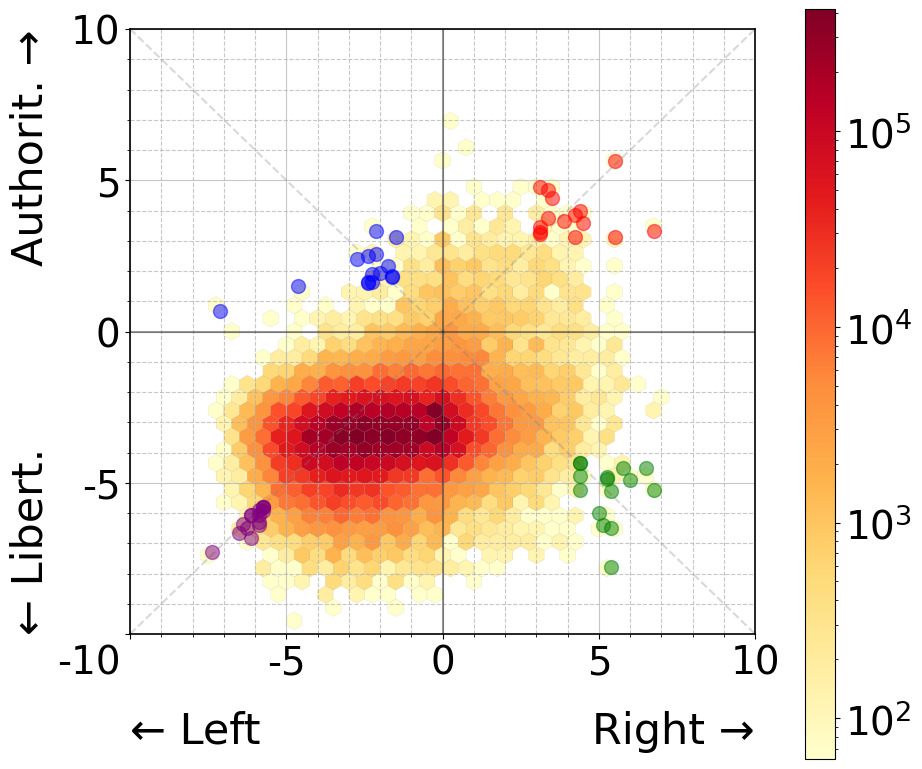

In [16]:
def plot_compass_positions(df, extreme_positions, n=5, bins='log', gridsize=30,
                        label_gap=1.5, label_margin=0.15, tick_interval=2,
                        label_size=10, tick_size=8, colorbar_size=8,
                        origin_lines_alpha=0.8):
    # Extract coordinates
    x = [pos[0] for pos in df['compass_position']]
    y = [pos[1] for pos in df['compass_position']]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Custom formatter function for axis ticks
    def custom_formatter(x, p):
        if x == -10:
            return ''
        if abs(x) >= 1000:
            return f'{int(x/1000)}k'
        return str(int(x))
    
    # Create the hexbin plot with borders
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap='YlOrRd', mincnt=1,
                   bins=bins, extent=(-10, 10, -10, 10),
                   edgecolors=(0, 0, 0, 0.3), linewidths=0.1)
    
    # Set the axis limits and ticks
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    # Set tick intervals
    ticks = np.arange(-10, 11, tick_interval)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    # Set minor grid lines
    grid_lines = np.arange(-10, 11, 1)
    ax.set_xticks(grid_lines, minor=True)
    ax.set_yticks(grid_lines, minor=True)
    
    # Show all spines
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(1.2)
    
    # Apply custom formatter
    ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(custom_formatter))
    
    # Set tick label size
    ax.tick_params(axis='both', labelsize=tick_size)
    
    # Remove default axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Adjust margins
    margin_size = label_gap / 20
    plt.subplots_adjust(left=0.15 + margin_size, bottom=0.15 + margin_size)
    
    # Add labels
    label_pos = 10 + label_gap
    ax.text(-10, -label_pos, '← Left', ha='left', va='top',
            transform=ax.transData, fontsize=label_size)
    ax.text(10, -label_pos, 'Right →', ha='right', va='top',
            transform=ax.transData, fontsize=label_size)
    ax.text(-label_pos, 10, 'Authorit. →', ha='right', va='top',
            rotation=90, transform=ax.transData, fontsize=label_size)
    ax.text(-label_pos, -10, '← Libert.', ha='right', va='bottom',
            rotation=90, transform=ax.transData, fontsize=label_size)
    
    # Add the -10 label
    ax.text(-10.3, -10.3, '-10', ha='right', va='top',
            transform=ax.transData, fontsize=tick_size)
    
    # Add grid lines
    ax.grid(True, which='major', linestyle='-', alpha=0.7)
    ax.grid(True, which='minor', linestyle='--', alpha=0.7)
    
    # Add diagonal lines
    ax.plot([-10, 10], [-10, 10], '--', color='gray', alpha=0.3)
    ax.plot([-10, 10], [10, -10], '--', color='gray', alpha=0.3)
    
    # Add center lines
    ax.axhline(y=0, color='k', linestyle='-', alpha=origin_lines_alpha, linewidth=1.5)
    ax.axvline(x=0, color='k', linestyle='-', alpha=origin_lines_alpha, linewidth=1.5)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.75])
    cbar = fig.colorbar(hb, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_size)
    
    # Plot extreme points
    colors = ['red', 'blue', 'green', 'purple']
    for (quadrant, positions), color in zip(extreme_positions.items(), colors):
        if positions:
            x_pos = [pos[2][0] for pos in positions]
            y_pos = [pos[2][1] for pos in positions]
            ax.scatter(x_pos, y_pos, color=color, s=100,
                      label=f'{quadrant}', zorder=5, alpha=0.5)
    
    return fig

fig = plot_compass_positions(df, 
                           extreme_pos,
                           bins='log',
                           gridsize=40,
                           label_gap=2.5,
                           label_margin=0.6,
                           tick_interval=5,
                           label_size=31,
                           tick_size=28,
                           colorbar_size=28,
                           origin_lines_alpha=0.4)
plt.show()